In [ ]:
from google.colab import drive
drive.mount('/content/Mydrive')

Mounted at /content/Mydrive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
#import seaborn as sns
import random
import time
import os
import copy

import torch.nn as nn
import os
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from torchvision.transforms.functional import crop
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, average_precision_score
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import cv2
from torch import topk

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Grad-CAM

In [ ]:
from google.colab.patches import cv2_imshow

class GradCam(nn.Module):
    def __init__(self, model, module, layer):
        super().__init__()
        self.model = model
        self.module = module
        self.layer = layer
        self.register_hooks()

    def register_hooks(self):
        for modue_name, module in self.model._modules.items():
            if modue_name == self.module:
                for layer_name, module in module._modules.items():
                    if layer_name == self.layer:
                        module.register_forward_hook(self.forward_hook)
                        module.register_backward_hook(self.backward_hook)

    def forward(self, input, target_index):
        outs = self.model(input)
        outs = outs.squeeze()  # [1, num_classes]  --> [num_classes]

        # 가장 큰 값을 가지는 것을 target index 로 사용
        if target_index is None:
            target_index = outs.argmax()

        outs[target_index].backward(retain_graph=True)
        a_k = torch.mean(self.backward_result, dim=(1, 2), keepdim=True)         # [512, 1, 1]
        out = torch.sum(a_k * self.forward_result, dim=0).cpu()                  # [512, 7, 7] * [512, 1, 1]
        out = torch.relu(out) / torch.max(out)  # 음수를 없애고, 0 ~ 1 로 scaling # [7, 7]
        out = F.upsample_bilinear(out.unsqueeze(0).unsqueeze(0), [224, 224])  # 4D로 바꿈
        return out.cpu().detach().squeeze().numpy()

    def forward_hook(self, _, input, output):
        self.forward_result = torch.squeeze(output)

    def backward_hook(self, _, grad_input, grad_output):
        self.backward_result = torch.squeeze(grad_output[0])


if __name__ == '__main__':

    def preprocess_image(img):

        preprocessed_img = img.copy()[:, :, ::-1]
        preprocessed_img = \
            np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
        preprocessed_img = torch.from_numpy(preprocessed_img)
        preprocessed_img.unsqueeze_(0)
        input = preprocessed_img.requires_grad_(True)
        return input.to(device)


    def show_cam_on_image(img, mask, save_path=None, filename=None):

        # mask = (np.max(mask) - np.min(mask)) / (mask - np.min(mask))
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        cam = np.uint8(255 * cam)
        heatmap = np.uint8(heatmap * 255)
        #cv2.imshow("cam", np.uint8(255 * cam))
        #cv2.imshow("heatmap", np.uint8(heatmap * 255))
        cv2_imshow(cam)
        cv2_imshow(heatmap)
        if filename is not None:
          cv2.imwrite(save_path+filename, heatmap)
        cv2.waitKey()

### Schizo(fake) vs Healthy

In [ ]:
weight_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/models/ResNet34F/Final/Schizophrenia_weight_test_auc_0.9592760180995475.pt'

model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load(weight_path))
model_ft.eval()

In [ ]:
grad_cam = GradCam(model=model_ft, module='layer4', layer='2')

In [ ]:
dataset_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Schizo(fake)/heatmap/'
img_list = os.listdir(dataset_path)
img_list

In [ ]:
save_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Schizo(fake)/CAM/'
for img_path in img_list:
  img = cv2.imread(dataset_path+img_path, 1)
  img = np.float32(cv2.resize(img, (224, 224))) / 255
  input = preprocess_image(img)
  mask = grad_cam(input, None)
  show_cam_on_image(img, mask, save_path, img_path)

#### result

In [ ]:
heatmap_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Schizo(fake)/heatmap/'
heatmap_list = sorted(os.listdir(heatmap_path))
cam_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Schizo(fake)/CAM/'
#cam_list = sorted(os.listdir(cam_path))

In [ ]:
test_preds = list()
test_labels = [1]*50
test_preds_prob = list()
for idx, filename in enumerate(heatmap_list):
    image=plt.imread(heatmap_path+filename)[:,:,:3]
    image=image[...,::-1]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    image_tensor = data_transforms(image)
    image_tensor = image_tensor.unsqueeze(0).to(device)

    output = model_ft(image_tensor)
    _, test_pred = torch.max(output, 1)

    testmodeloutput= F.softmax(output, dim=1)
    test_pred_prob = testmodeloutput[:,1]

    for i in test_pred:
        test_preds.append(i.item())

    for k in test_pred_prob:
        test_preds_prob.append(k.item())

fpr, tpr, thresholds = metrics.roc_curve(test_labels, test_preds_prob)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                                 estimator_name = 'Best test auc')

In [ ]:
test_preds_prob

[0.9871975183486938,
 0.9849334359169006,
 0.9872466325759888,
 0.979528546333313,
 0.984596312046051,
 0.983824610710144,
 0.985956072807312,
 0.9870330095291138,
 0.9877891540527344,
 0.9857229590415955,
 0.9831181764602661,
 0.9786096811294556,
 0.9868758916854858,
 0.9878514409065247,
 0.9861578941345215,
 0.989264965057373,
 0.9828832745552063,
 0.9855660796165466,
 0.9874711632728577,
 0.9872717261314392,
 0.9863563776016235,
 0.984975278377533,
 0.9875696301460266,
 0.9862852096557617,
 0.9869199991226196,
 0.9722842574119568,
 0.9839532971382141,
 0.9807243347167969,
 0.988531231880188,
 0.9866548776626587,
 0.9738871455192566,
 0.9808238744735718,
 0.9832466244697571,
 0.9817293286323547,
 0.986739993095398,
 0.984283447265625,
 0.9547897577285767,
 0.9845975637435913,
 0.984980583190918,
 0.9784335494041443,
 0.9867938160896301,
 0.9876254200935364,
 0.9872168898582458,
 0.9762986302375793,
 0.9856961965560913,
 0.9742956757545471,
 0.9811968207359314,
 0.9868950843811035,
 0

In [ ]:
for idx, filename in enumerate(heatmap_list):
  heatmap_img = cv2.imread(heatmap_path+filename)
  plt.subplot(1,2,1)
  plt.imshow(heatmap_img[:,:,::-1])
  plt.title(filename+'pred:'+str(test_preds_prob[idx]))
  plt.xticks([])
  plt.yticks([])

  cam_img = cv2.imread(cam_path+filename)
  plt.subplot(1,2,2)
  plt.imshow(cam_img[:,:,::-1]) # BGR -> RGB
  plt.title('CAM')
  plt.xticks([])
  plt.yticks([])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Depressive(fake)

In [ ]:
weight_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/models/ResNet34F/Final/depressive_weight_test_auc_0.9361702127659575.pt'

model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load(weight_path))
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
grad_cam = GradCam(model=model_ft, module='layer4', layer='2')

In [ ]:
dataset_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Depressive(fake)/heatmap/'
img_list = os.listdir(dataset_path)
img_list

In [ ]:
save_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Depressive(fake)/CAM/'
for img_path in img_list:
  img = cv2.imread(dataset_path+img_path, 1)
  img = np.float32(cv2.resize(img, (224, 224))) / 255
  input = preprocess_image(img)
  mask = grad_cam(input, None)
  show_cam_on_image(img, mask, save_path, img_path)

#### result

In [ ]:
heatmap_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Depressive(fake)/heatmap/'
heatmap_list = sorted(os.listdir(heatmap_path))
cam_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Depressive(fake)/CAM/'
#cam_list = sorted(os.listdir(cam_path))

In [ ]:
test_preds = list()
test_labels = [1]*50
test_preds_prob = list()
for idx, filename in enumerate(heatmap_list):
    image=plt.imread(heatmap_path+filename)[:,:,:3]
    image=image[...,::-1]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    image_tensor = data_transforms(image)
    image_tensor = image_tensor.unsqueeze(0).to(device)

    output = model_ft(image_tensor)
    _, test_pred = torch.max(output, 1)

    testmodeloutput= F.softmax(output, dim=1)
    test_pred_prob = testmodeloutput[:,1]

    for i in test_pred:
        test_preds.append(i.item())

    for k in test_pred_prob:
        test_preds_prob.append(k.item())

fpr, tpr, thresholds = metrics.roc_curve(test_labels, test_preds_prob)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                                 estimator_name = 'Best test auc')

In [ ]:
test_preds

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

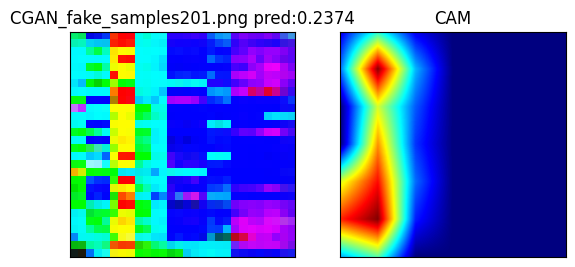

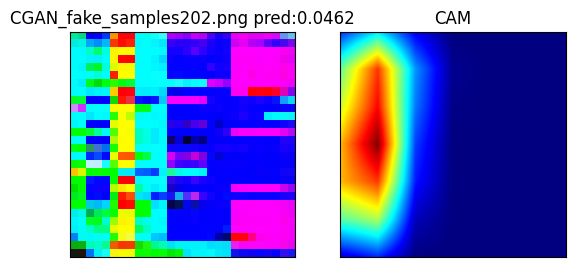

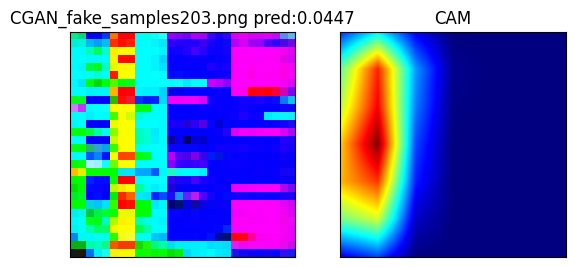

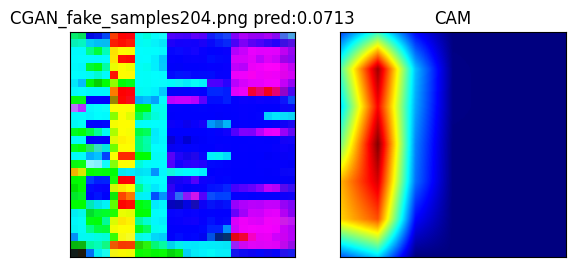

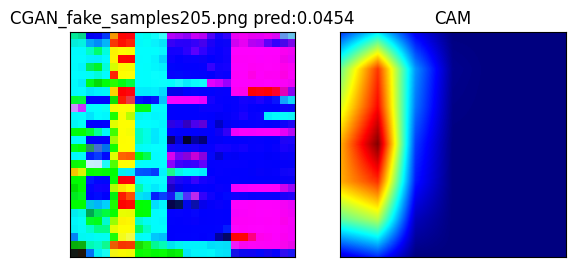

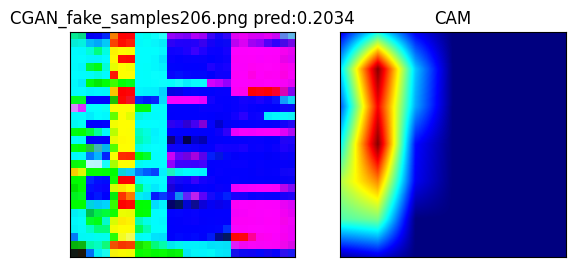

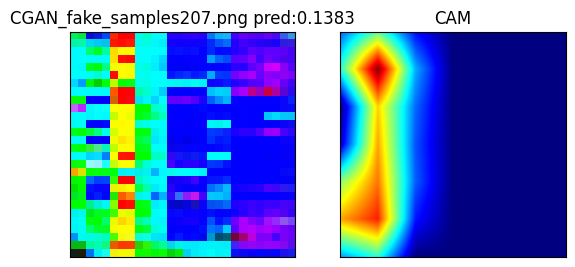

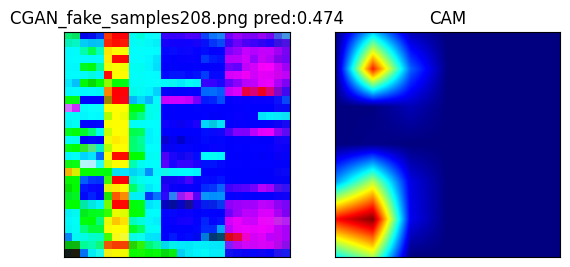

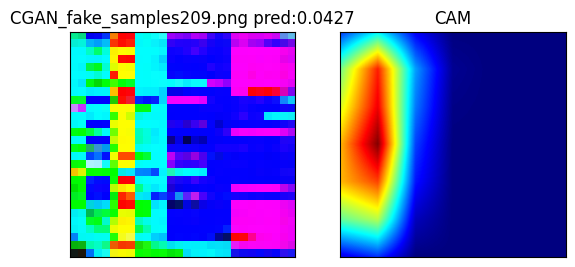

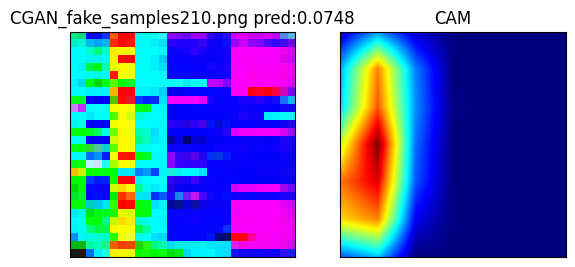

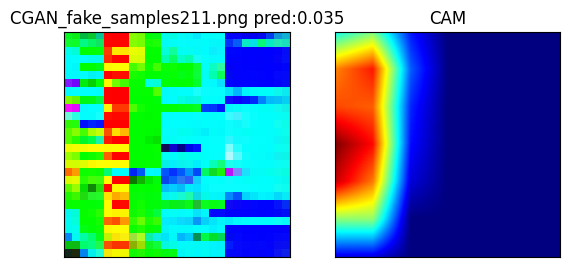

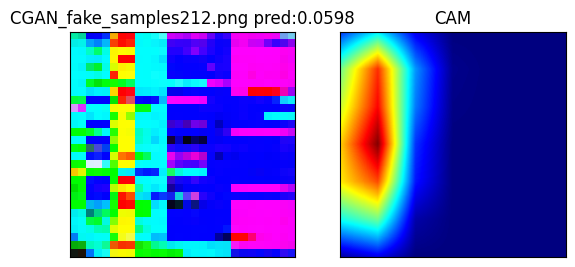

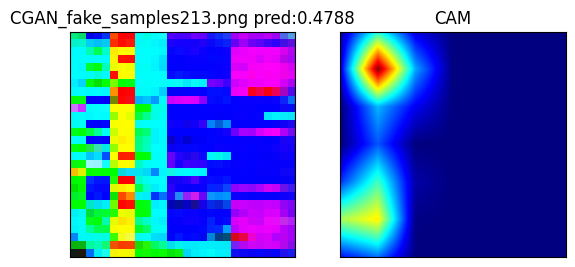

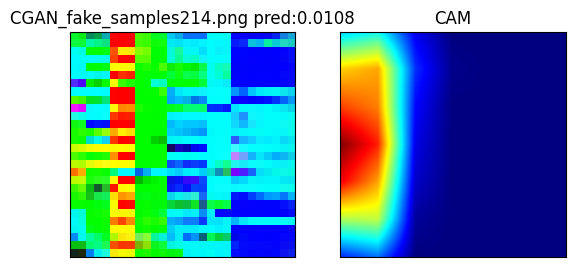

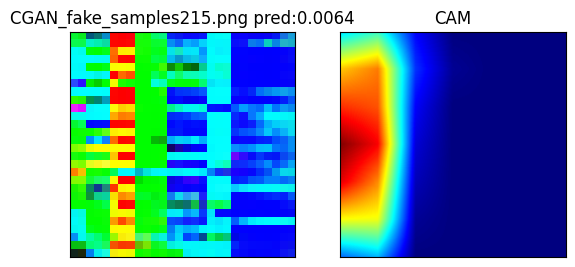

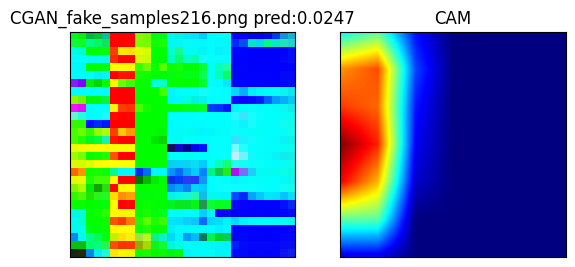

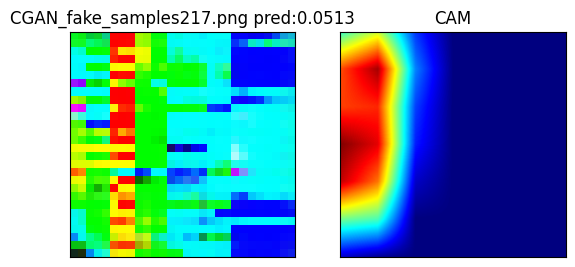

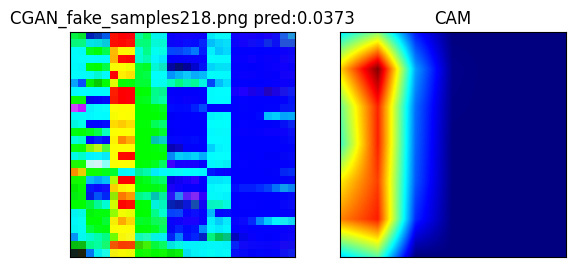

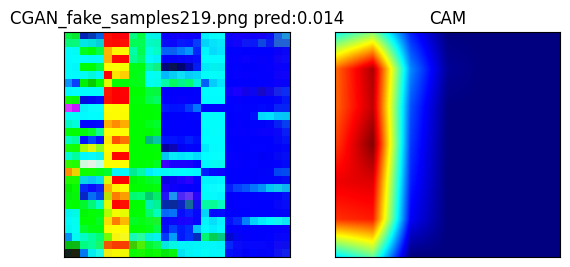

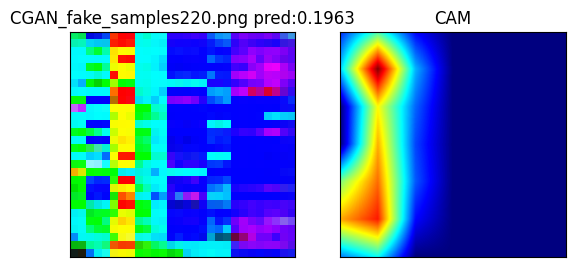

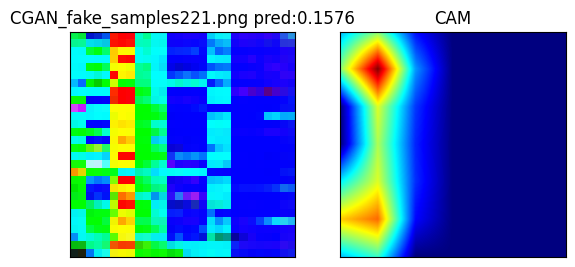

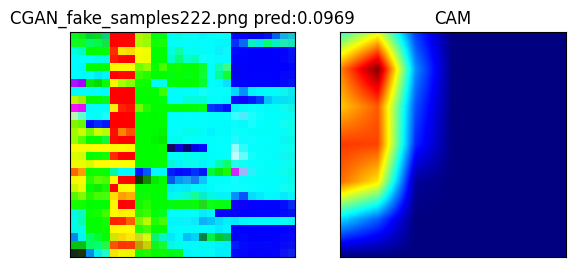

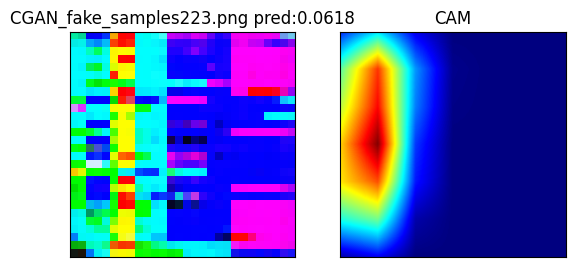

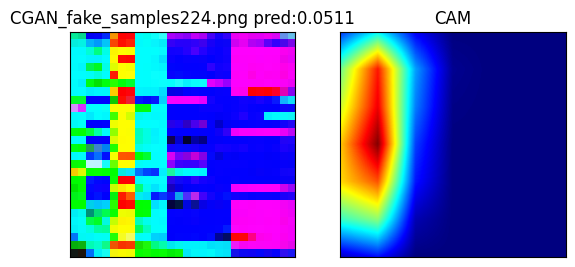

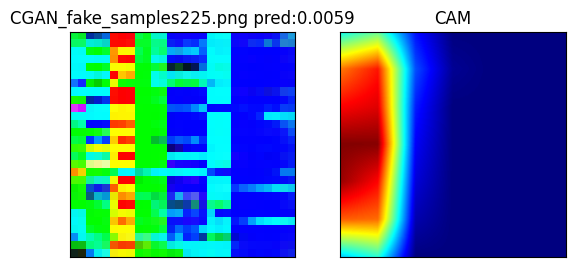

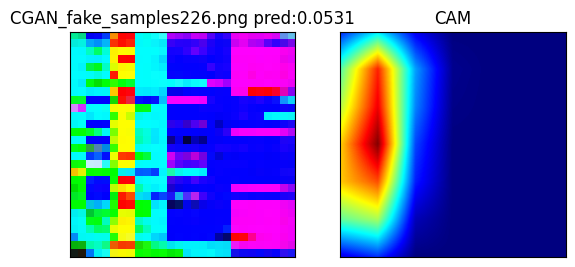

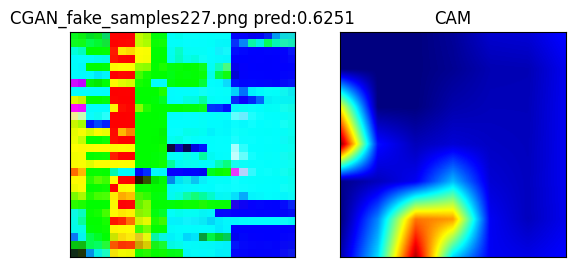

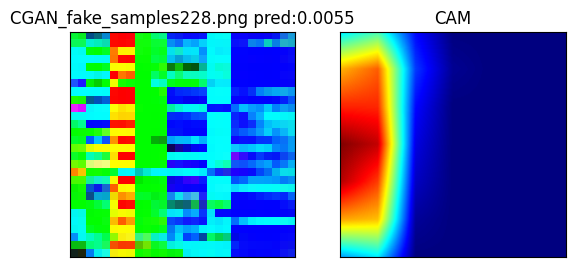

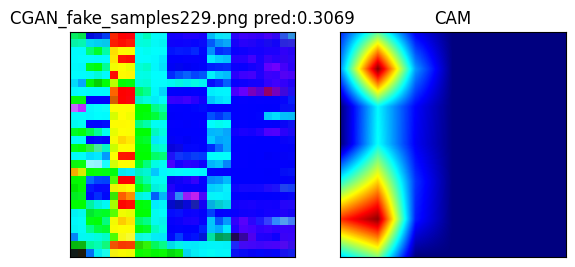

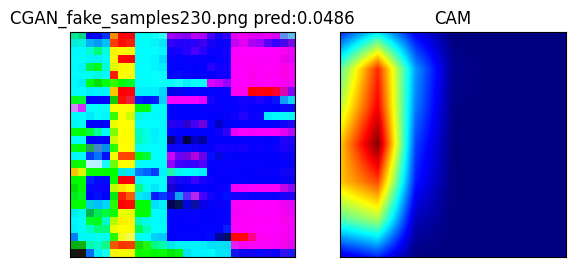

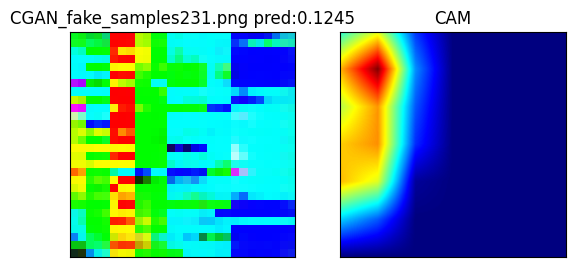

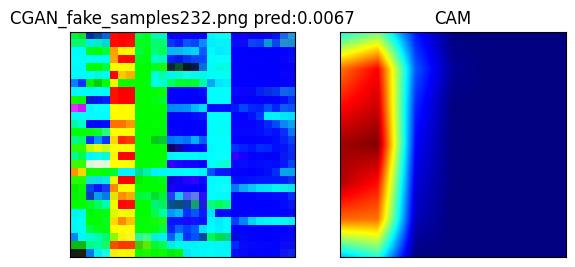

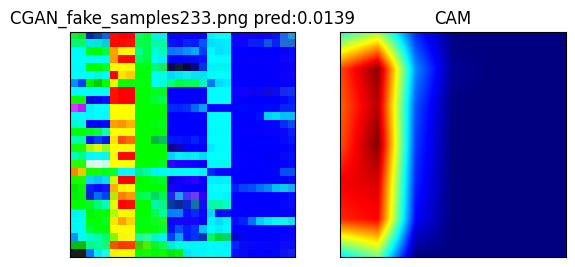

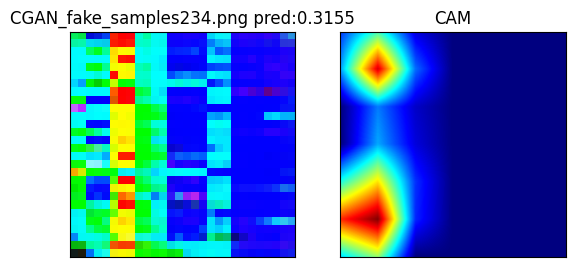

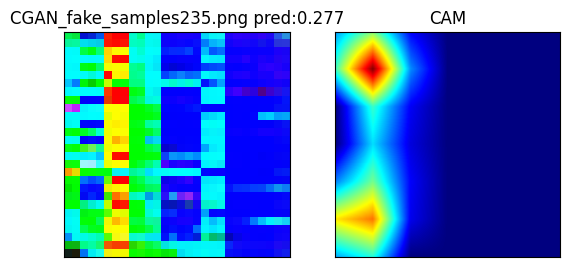

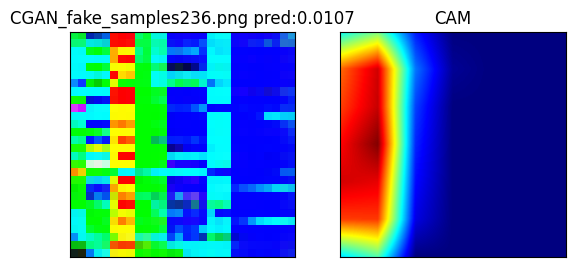

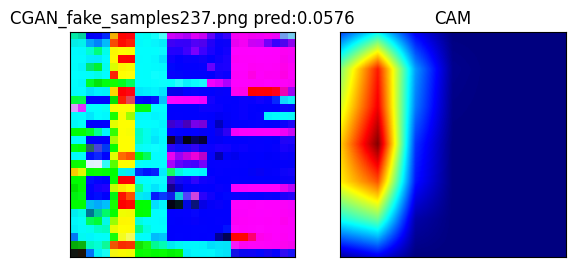

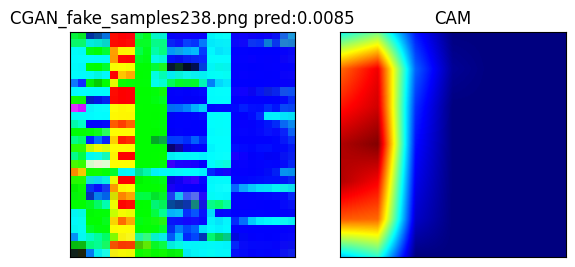

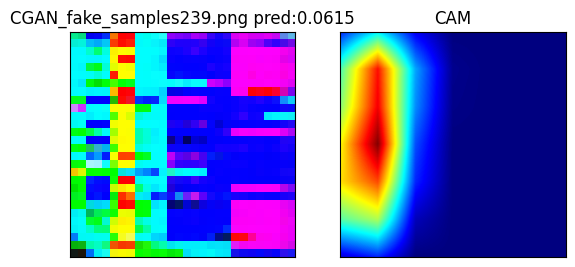

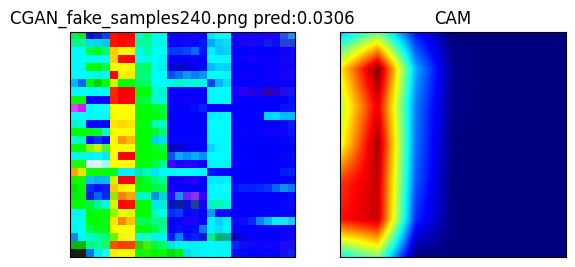

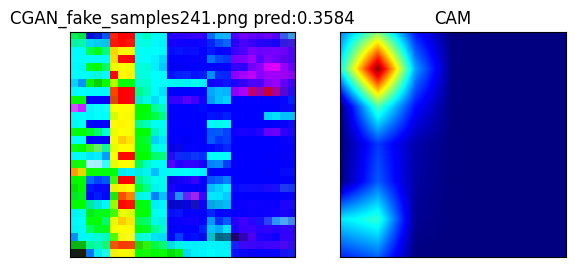

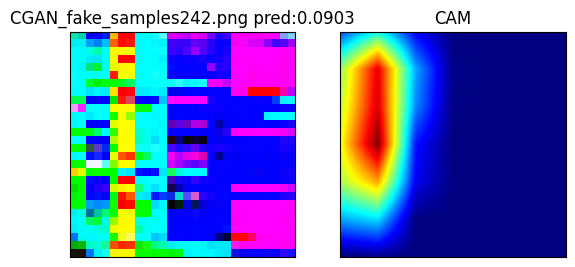

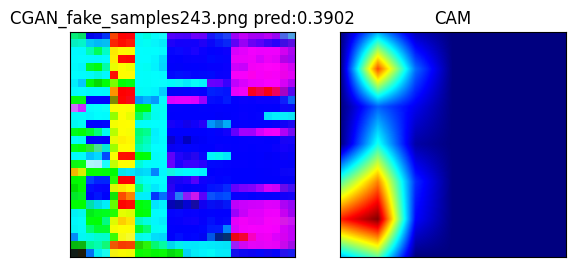

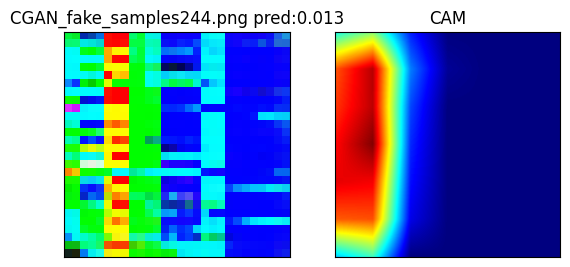

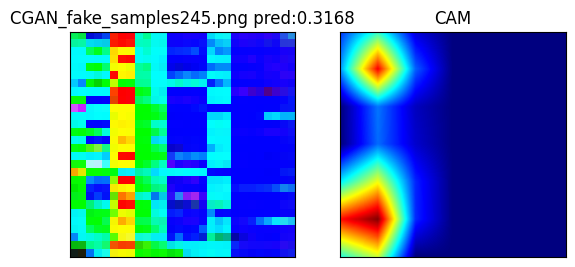

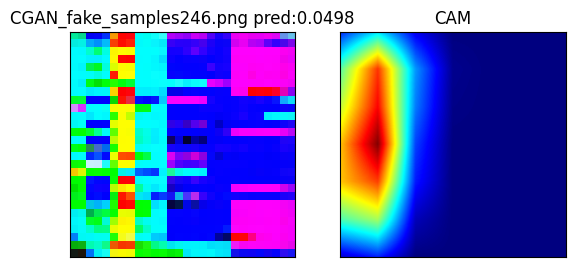

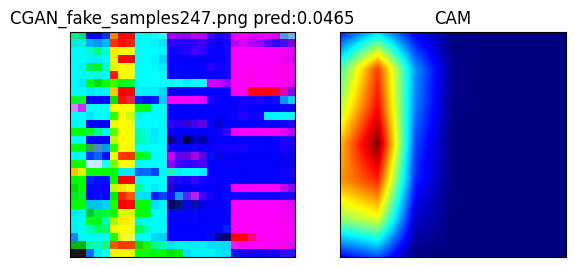

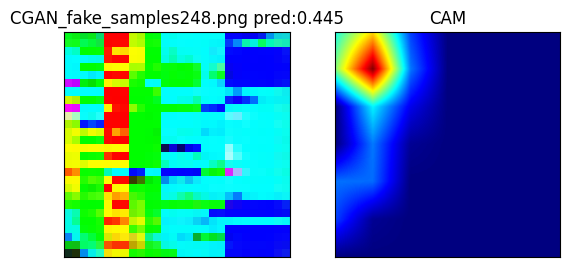

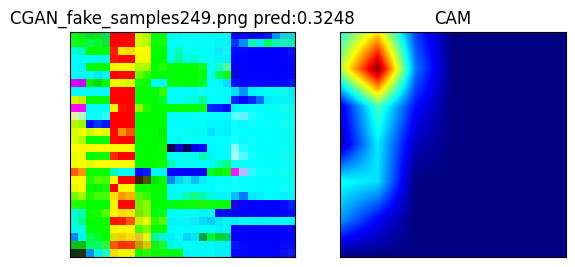

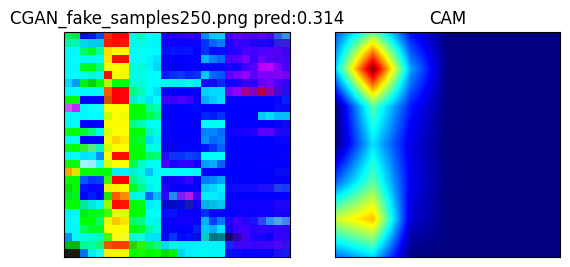

In [ ]:
for idx, filename in enumerate(heatmap_list):
  heatmap_img = cv2.imread(heatmap_path+filename)
  plt.subplot(1,2,1)
  plt.imshow(heatmap_img[:,:,::-1])
  plt.title(filename+' pred:'+str(round(test_preds_prob[idx], 4)))
  plt.xticks([])
  plt.yticks([])

  cam_img = cv2.imread(cam_path+filename)
  plt.subplot(1,2,2)
  plt.imshow(cam_img[:,:,::-1]) # BGR -> RGB
  plt.title('CAM')
  plt.xticks([])
  plt.yticks([])
  plt.show()

### Bipolar(fake)

In [ ]:
weight_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/models/ResNet34F/Final/bipolar2_weight_test_auc_0.8733459357277884.pt'

model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load(weight_path))
model_ft.eval()

In [ ]:
grad_cam = GradCam(model=model_ft, module='layer4', layer='2')

In [ ]:
dataset_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Bipolar(fake)/heatmap/'
img_list = os.listdir(dataset_path)
len(img_list)

In [ ]:
save_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Bipolar(fake)/CAM/'
for img_path in img_list:
  img = cv2.imread(dataset_path+img_path, 1)
  img = np.float32(cv2.resize(img, (224, 224))) / 255
  input = preprocess_image(img)
  mask = grad_cam(input, None)
  show_cam_on_image(img, mask, save_path, img_path)

#### result

In [ ]:
heatmap_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Bipolar(fake)/heatmap/'
heatmap_list = sorted(os.listdir(heatmap_path))
cam_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Bipolar(fake)/CAM/'
#cam_list = sorted(os.listdir(cam_path))

In [ ]:
test_preds = list()
test_labels = [1]*50
test_preds_prob = list()
for idx, filename in enumerate(heatmap_list):
    image=plt.imread(heatmap_path+filename)[:,:,:3]
    image=image[...,::-1]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    image_tensor = data_transforms(image)
    image_tensor = image_tensor.unsqueeze(0).to(device)

    output = model_ft(image_tensor)
    _, test_pred = torch.max(output, 1)

    testmodeloutput= F.softmax(output, dim=1)
    test_pred_prob = testmodeloutput[:,1]

    for i in test_pred:
        test_preds.append(i.item())

    for k in test_pred_prob:
        test_preds_prob.append(k.item())

fpr, tpr, thresholds = metrics.roc_curve(test_labels, test_preds_prob)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                                 estimator_name = 'Best test auc')

In [ ]:
test_preds

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
for idx, filename in enumerate(heatmap_list):
  heatmap_img = cv2.imread(heatmap_path+filename)
  plt.subplot(1,2,1)
  plt.imshow(heatmap_img[:,:,::-1])
  plt.title(filename+' pred:'+str(round(test_preds_prob[idx], 4)))
  plt.xticks([])
  plt.yticks([])

  cam_img = cv2.imread(cam_path+filename)
  plt.subplot(1,2,2)
  plt.imshow(cam_img[:,:,::-1]) # BGR -> RGB
  plt.title('CAM')
  plt.xticks([])
  plt.yticks([])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Schizo vs Healthy

In [ ]:
weight_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/models/ResNet34F/Final/Schizophrenia_weight_test_auc_0.9592760180995475.pt'

model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load(weight_path))
model_ft.eval()

In [ ]:
grad_cam = GradCam(model=model_ft, module='layer4', layer='2')

In [ ]:
dataset_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM(schizo)/heatmap/'
img_list = os.listdir(dataset_path)
img_list

In [ ]:
for img_path in img_list:
  img = cv2.imread(dataset_path+img_path, 1)
  img = np.float32(cv2.resize(img, (224, 224))) / 255
  input = preprocess_image(img)
  mask = grad_cam(input, None)
  save_name = img_path
  show_cam_on_image(img, mask, img_path)

In [ ]:
from google.colab.patches import cv2_imshow
img = cv2.imread(dataset_path+img_list[10], 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
input = preprocess_image(img)
mask = grad_cam(input, None)
show_cam_on_image(img, mask)

#### result

In [ ]:
heatmap_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM(schizo)/heatmap/'
heatmap_list = sorted(os.listdir(heatmap_path))
cam_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM(schizo)/CAM result/'
#cam_list = sorted(os.listdir(cam_path))

In [ ]:
answer = test_labels
prediction = y_prob_pred.astype(int)

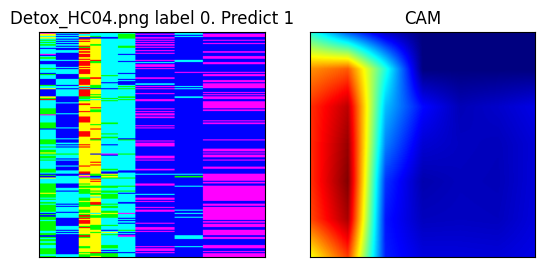

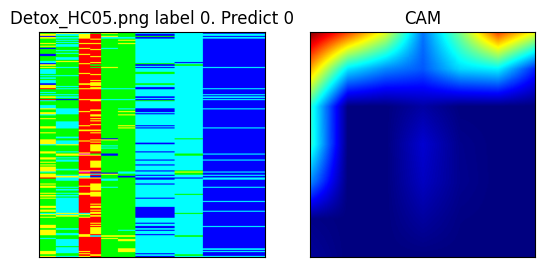

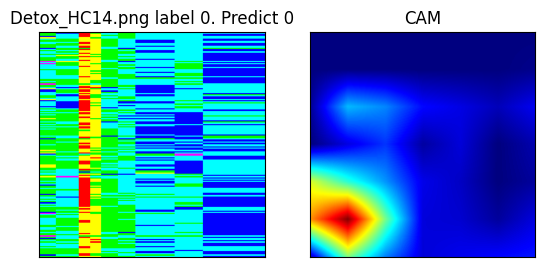

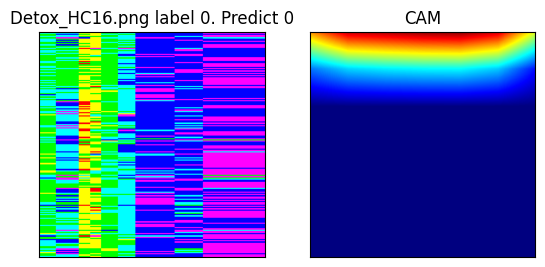

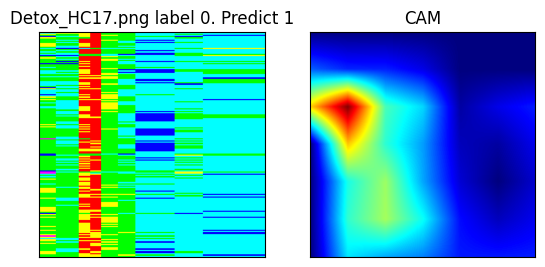

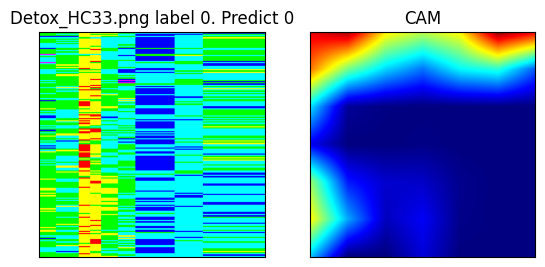

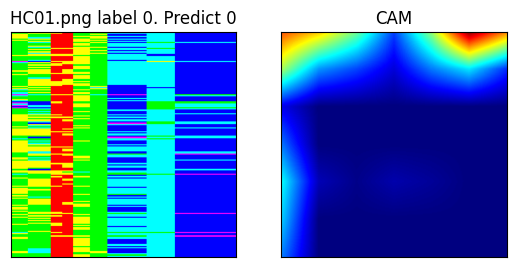

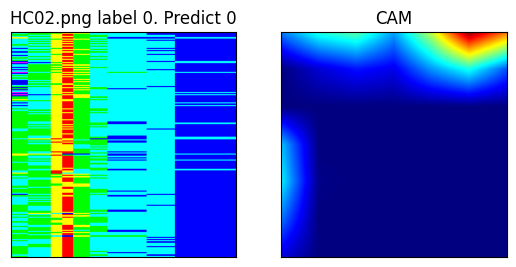

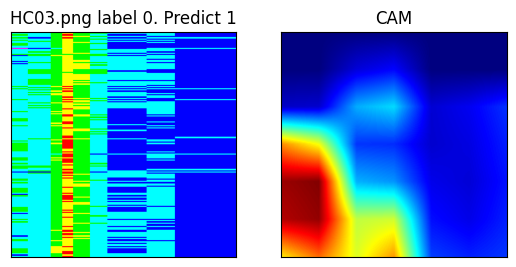

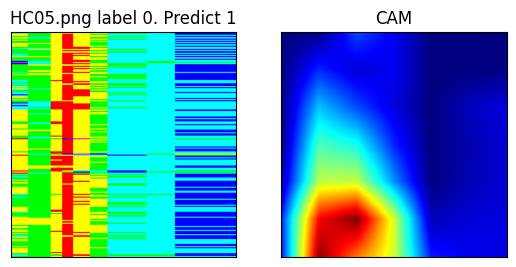

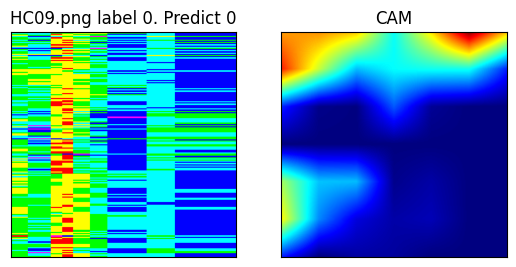

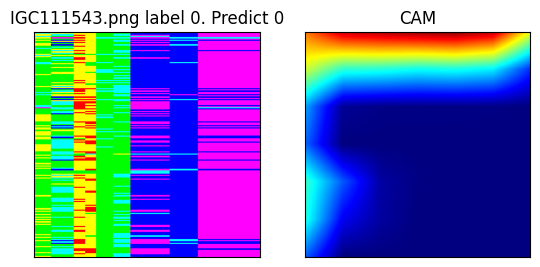

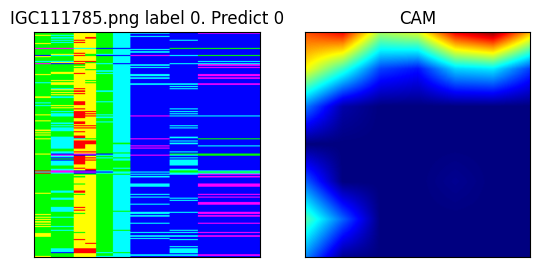

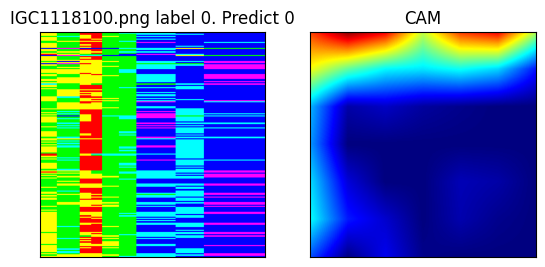

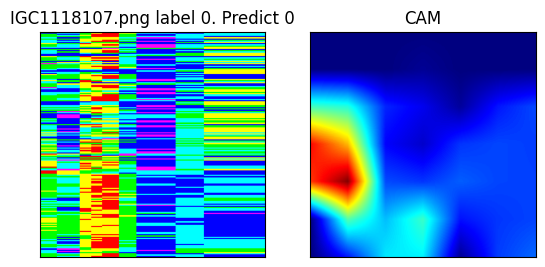

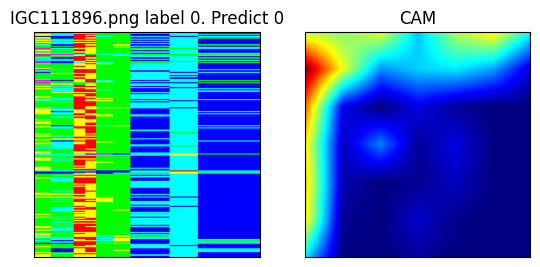

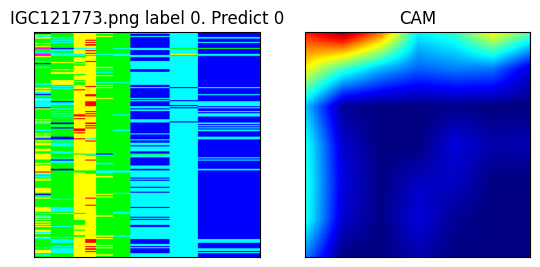

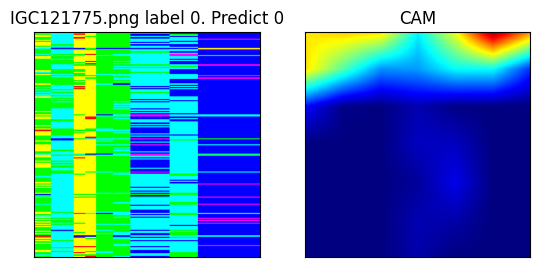

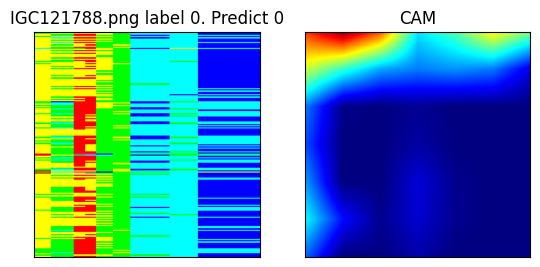

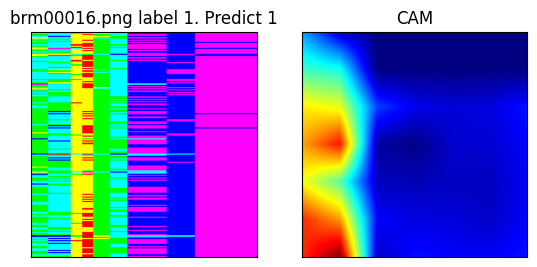

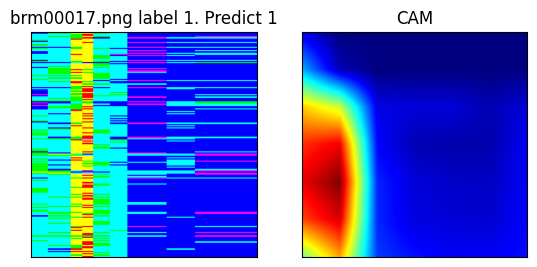

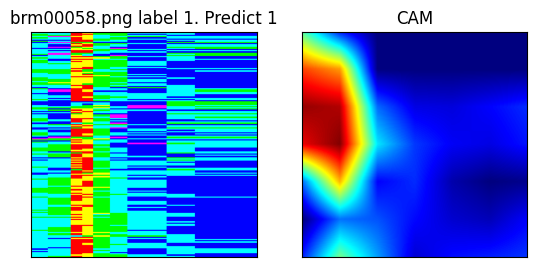

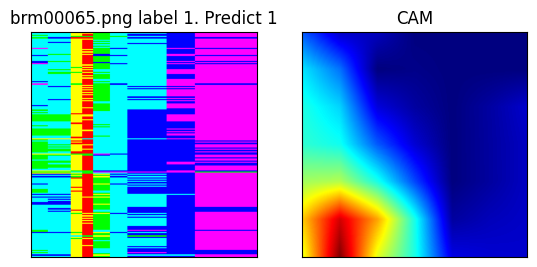

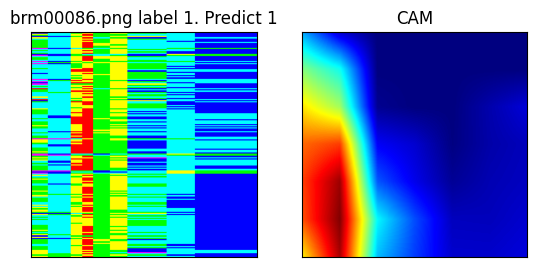

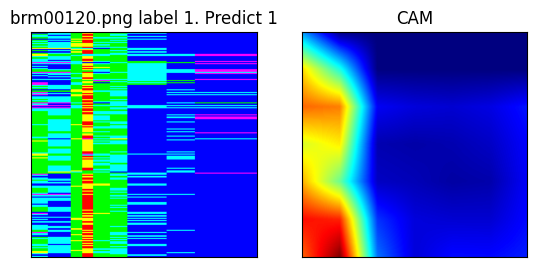

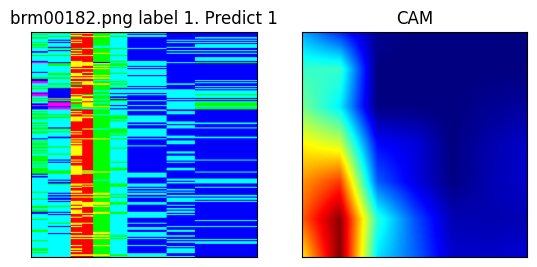

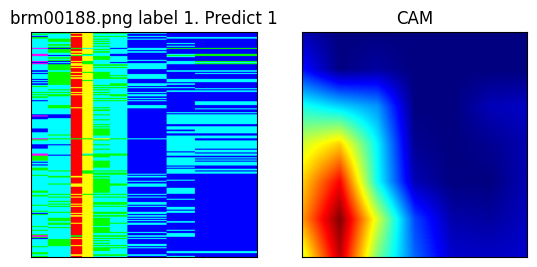

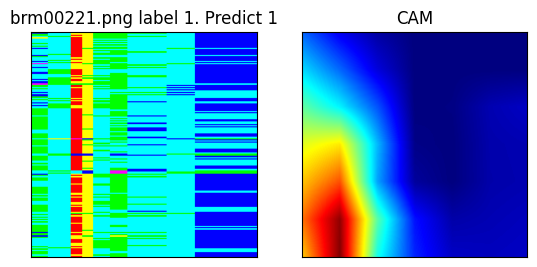

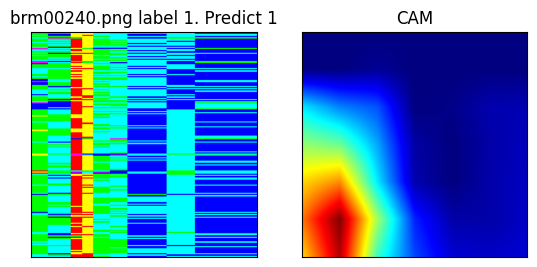

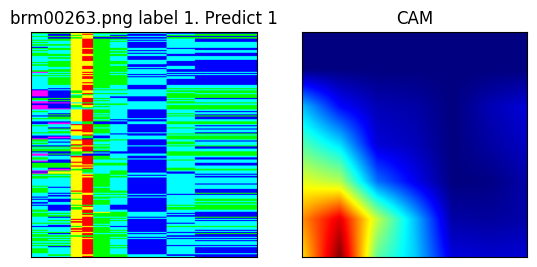

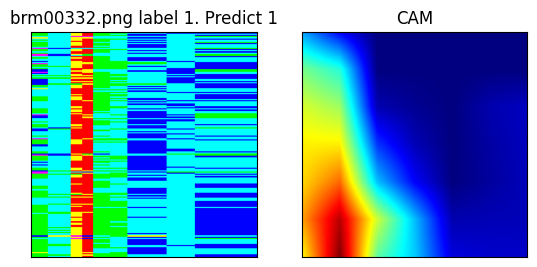

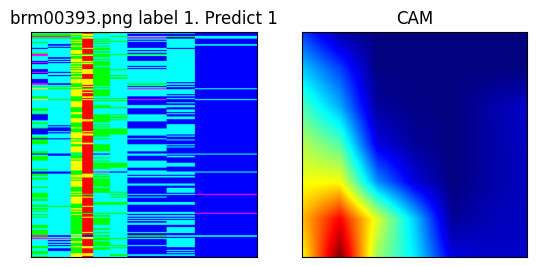

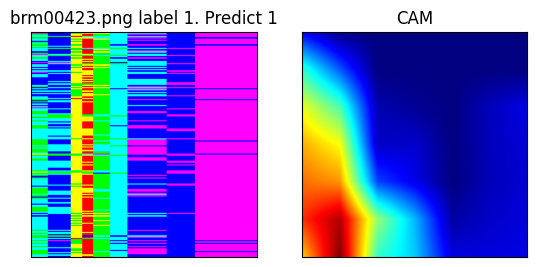

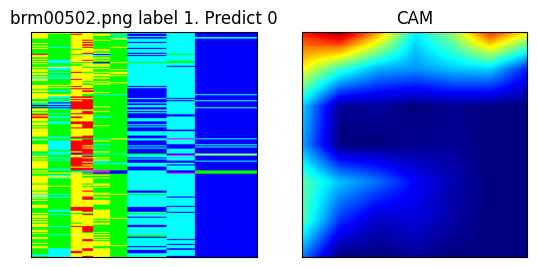

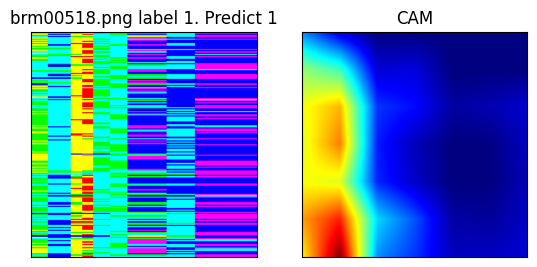

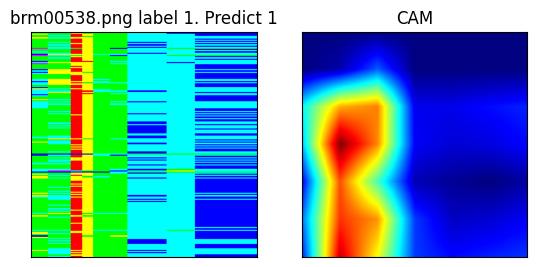

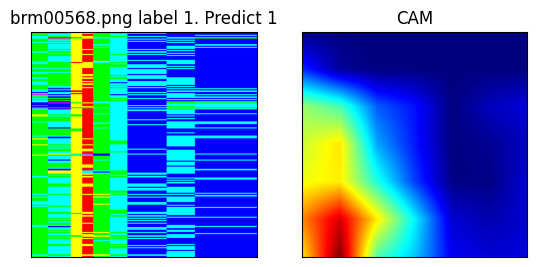

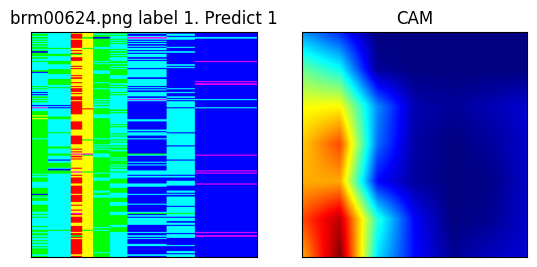

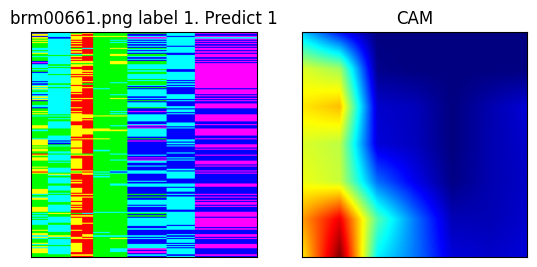

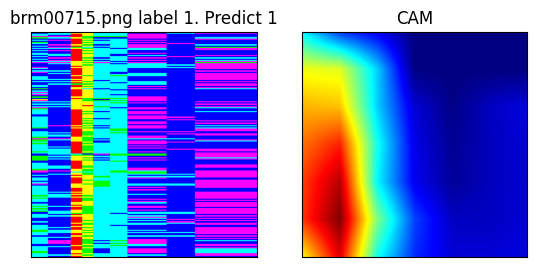

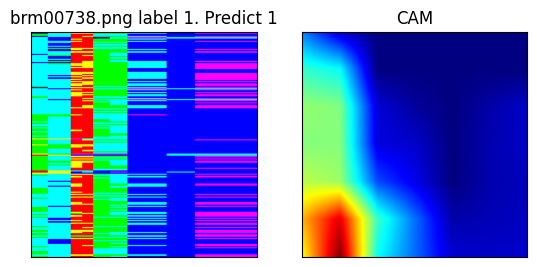

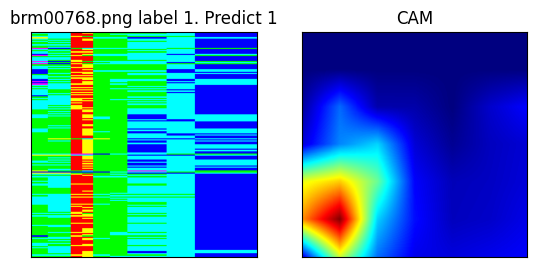

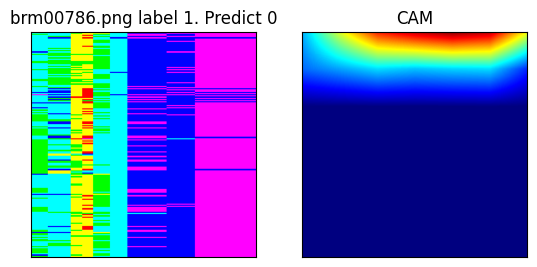

In [ ]:
for idx, filename in enumerate(heatmap_list):
  heatmap_img = cv2.imread(heatmap_path+filename)
  plt.subplot(1,2,1)
  plt.imshow(heatmap_img[:,:,::-1])
  plt.title(filename+' label ' + str(answer[idx]) + '. Predict ' + str(prediction[idx]))
  plt.xticks([])
  plt.yticks([])

  cam_img = cv2.imread(cam_path+filename)
  plt.subplot(1,2,2)
  plt.imshow(cam_img[:,:,::-1]) # BGR -> RGB
  plt.title('CAM')
  plt.xticks([])
  plt.yticks([])
  plt.show()

### Depressive vs Healthy

In [ ]:
weight_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/models/ResNet34F/Final/depressive_weight_test_auc_0.9361702127659575.pt'

model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load(weight_path))
model_ft.eval()

In [ ]:
grad_cam = GradCam(model=model_ft, module='layer4', layer='2')

In [ ]:
dataset_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Depressive/heatmap/'
img_list = os.listdir(dataset_path)
img_list

In [ ]:
save_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Depressive/CAM/'
for img_path in img_list:
  img = cv2.imread(dataset_path+img_path, 1)
  img = np.float32(cv2.resize(img, (224, 224))) / 255
  input = preprocess_image(img)
  mask = grad_cam(input, None)
  show_cam_on_image(img, mask, save_path, img_path)

#### result

In [ ]:
heatmap_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Depressive/heatmap/'
#heatmap_list = os.listdir(heatmap_path)
cam_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Depressive/CAM/'
#cam_list = sorted(os.listdir(cam_path))

In [ ]:
answer = test_labels
prediction = y_prob_pred.astype(int)

In [ ]:
for idx, filename in enumerate(fileset):
  heatmap_img = cv2.imread(heatmap_path+filename)
  plt.subplot(1,2,1)
  plt.imshow(heatmap_img[:,:,::-1])
  plt.title(filename+' label ' + str(answer[idx]) + '. Predict ' + str(prediction[idx]))
  plt.xticks([])
  plt.yticks([])

  cam_img = cv2.imread(cam_path+filename)
  plt.subplot(1,2,2)
  plt.imshow(cam_img[:,:,::-1]) # BGR -> RGB
  plt.title('CAM')
  plt.xticks([])
  plt.yticks([])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Bipolar vs Healthy

In [ ]:
weight_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/models/ResNet34F/Final/bipolar2_weight_test_auc_0.8733459357277884.pt'

model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load(weight_path))
model_ft.eval()

In [ ]:
grad_cam = GradCam(model=model_ft, module='layer4', layer='2')

In [ ]:
dataset_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Bipolar/heatmap/'
img_list = os.listdir(dataset_path)
img_list

['brm00501.png',
 'brm00535.png',
 'brm00458.png',
 'brm00451.png',
 'brm00197.png',
 'brm00244.png',
 'brm00082.png',
 'brm00201.png',
 'brm00399.png',
 'brm00370.png',
 'brm00206.png',
 'brm00449.png',
 'brm00745.png',
 'Detox_HC17.png',
 'HC02.png',
 'Detox_HC16.png',
 'HC01.png',
 'Detox_HC33.png',
 'brm00674.png',
 'HC03.png',
 'Detox_HC14.png',
 'HC05.png',
 'Detox_HC05.png',
 'Detox_HC04.png',
 'IGC121788.png',
 'IGC1118100.png',
 'IGC121775.png',
 'IGC121773.png',
 'IGC111543.png',
 'IGC111896.png',
 'IGC111785.png',
 'IGC1118107.png',
 'HC09.png']

In [ ]:
save_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Bipolar/CAM/'
for img_path in img_list:
  img = cv2.imread(dataset_path+img_path, 1)
  img = np.float32(cv2.resize(img, (224, 224))) / 255
  input = preprocess_image(img)
  mask = grad_cam(input, None)
  show_cam_on_image(img, mask, save_path, img_path)

#### result

In [ ]:
heatmap_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Bipolar/heatmap/'
heatmap_list = sorted(os.listdir(heatmap_path))
cam_path = '/content/Mydrive/MyDrive/공유EEG/CODE/우리코드/CAM/Bipolar/CAM/'
#cam_list = sorted(os.listdir(cam_path))

In [ ]:
answer = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 1]
prediction = [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]

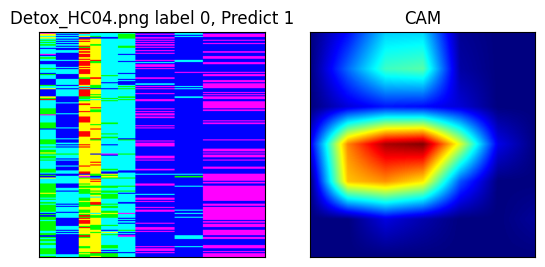

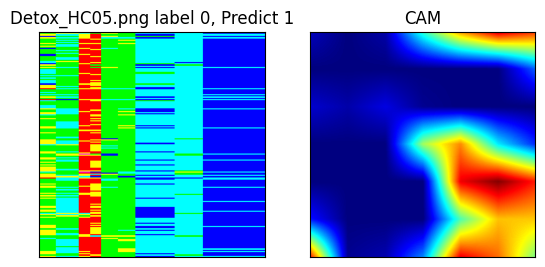

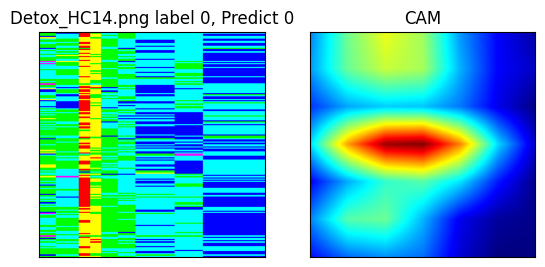

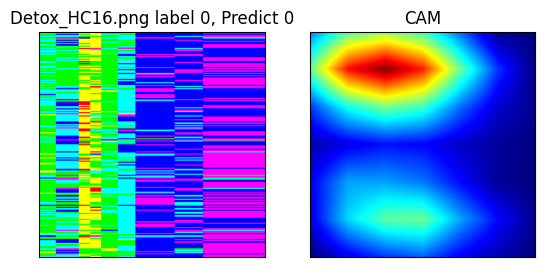

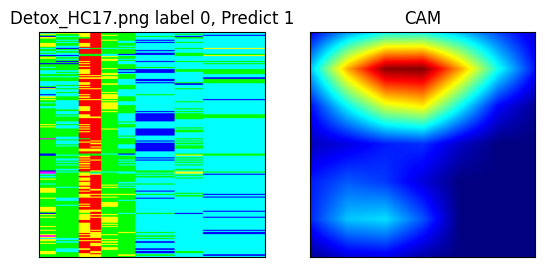

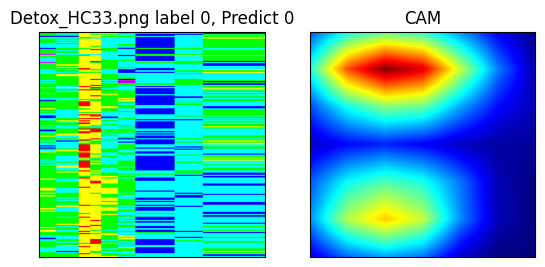

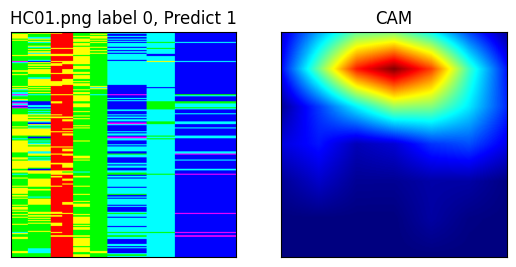

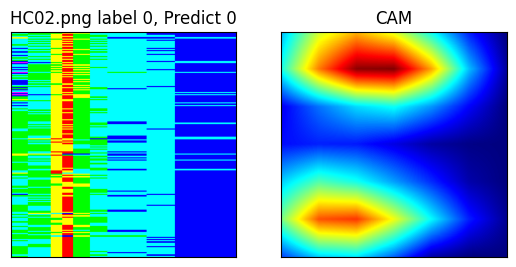

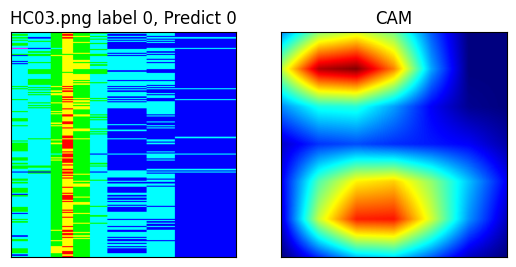

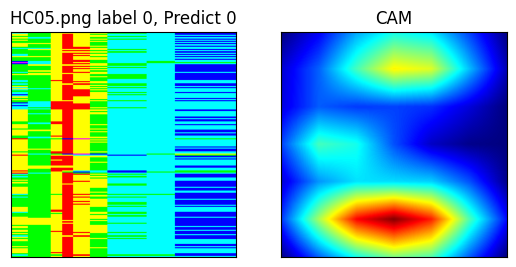

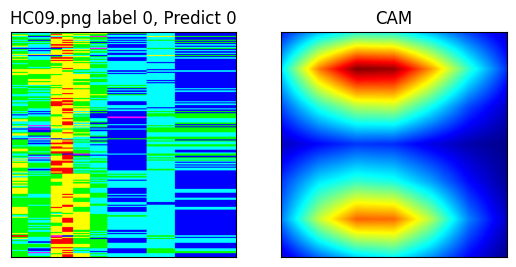

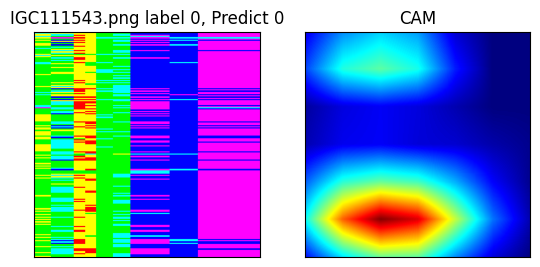

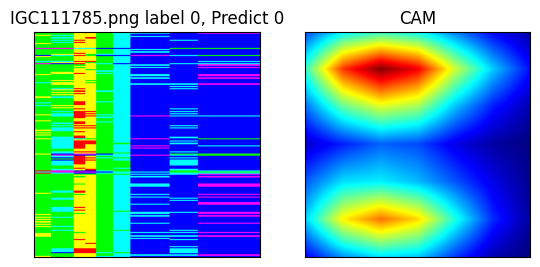

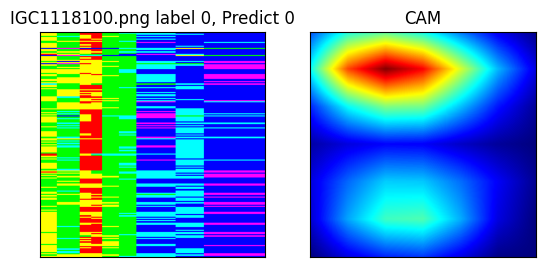

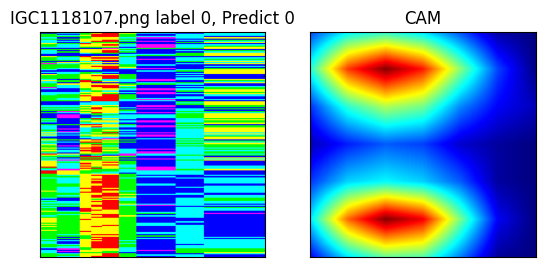

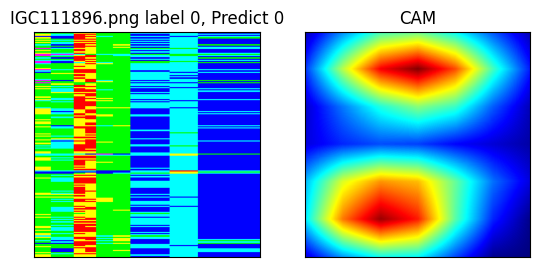

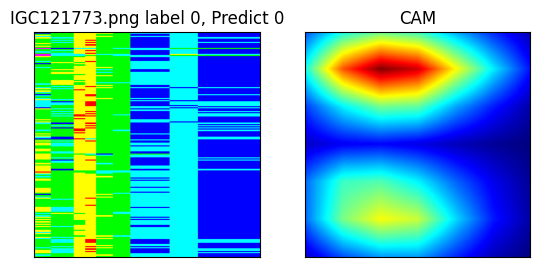

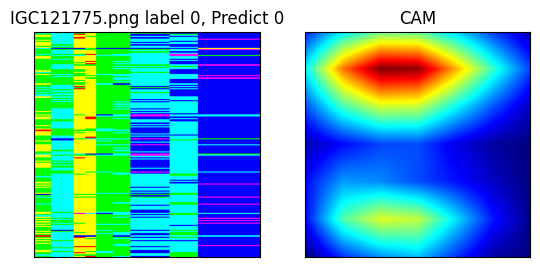

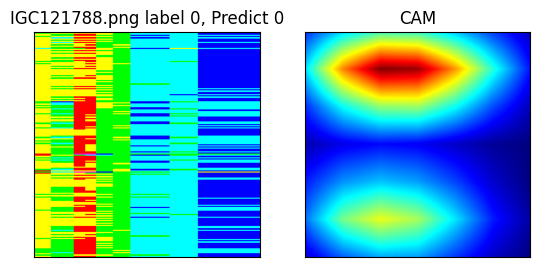

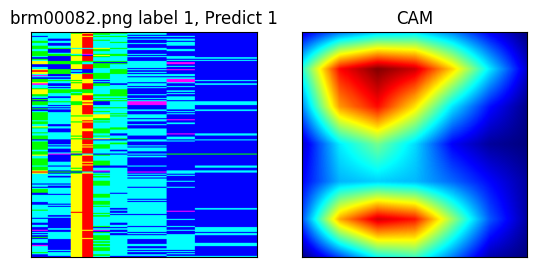

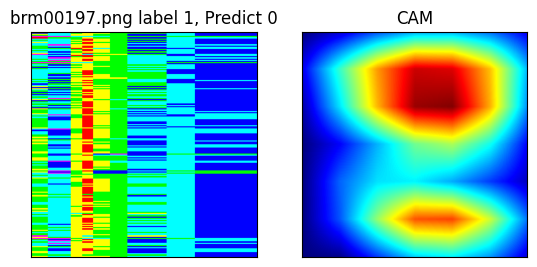

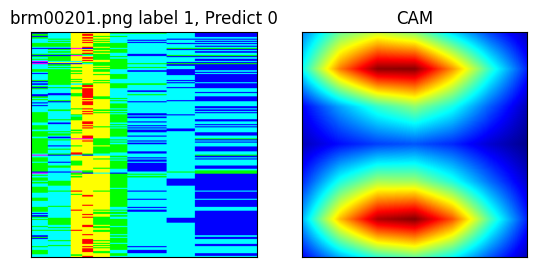

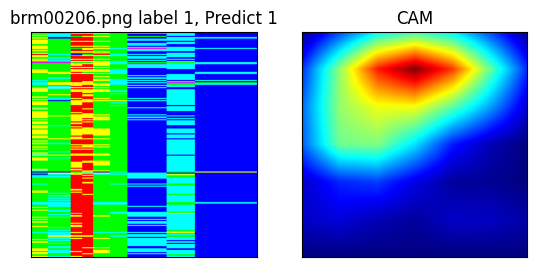

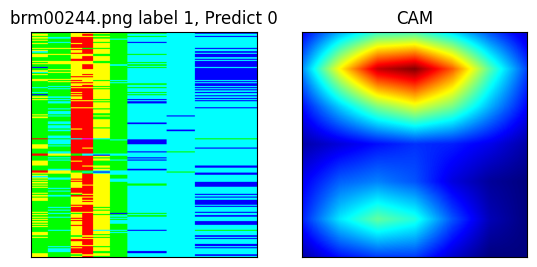

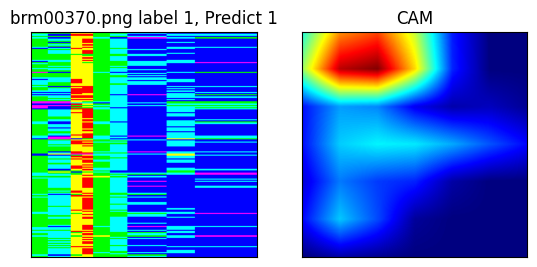

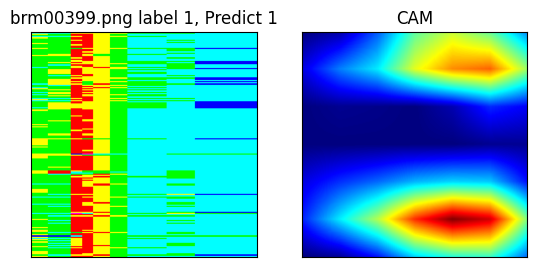

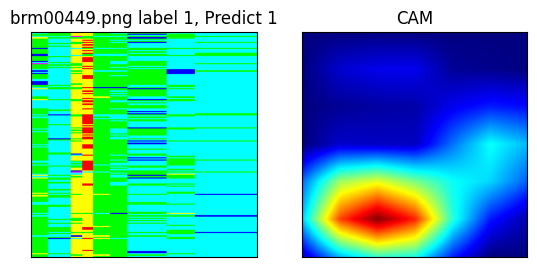

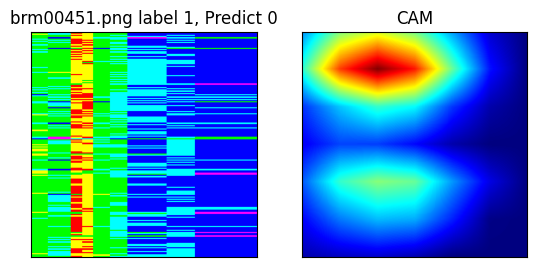

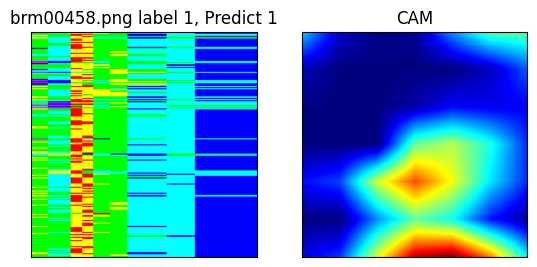

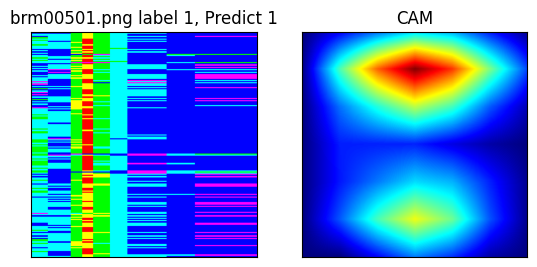

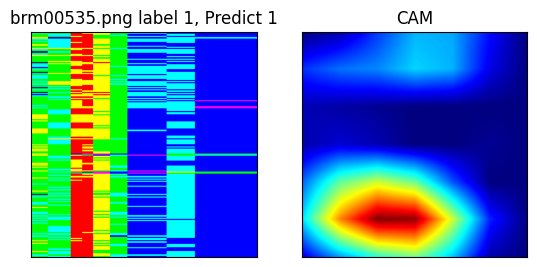

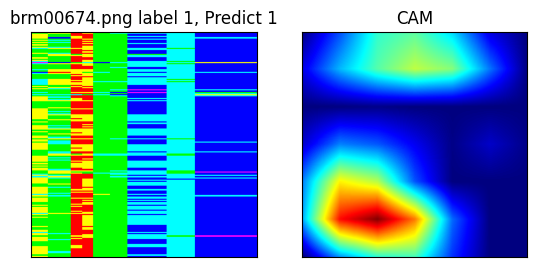

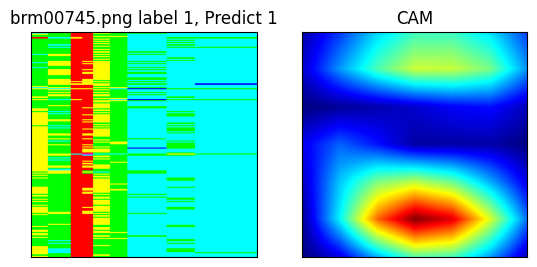

In [ ]:
for idx, filename in enumerate(heatmap_list):
  heatmap_img = cv2.imread(heatmap_path+filename)
  plt.subplot(1,2,1)
  plt.imshow(heatmap_img[:,:,::-1])
  plt.title(filename+' label ' + str(answer[idx]) + ', Predict ' + str(prediction[idx]))
  plt.xticks([])
  plt.yticks([])

  cam_img = cv2.imread(cam_path+filename)
  plt.subplot(1,2,2)
  plt.imshow(cam_img[:,:,::-1]) # BGR -> RGB
  plt.title('CAM')
  plt.xticks([])
  plt.yticks([])
  plt.show()